In [1]:
args = {
    'arms': '10', #numbers of arms in MAB problems
    'non_stationary': False, #flag for non-stationary environment
    'mutation_mag': '0.01', #mutation magnitude
    'pop_size': '50', #population size
    'max_gen': '200',#number of generations
    'hidden': '32', #number of nodes in each layer
    'layers': '1', #number of layers
    'name': 'UCBvsES', #name of the experiment
    'save_result': True, #flag for saving the result
    'noise': False, #add noise in the output layer of ANN
    'trials': '100', #number arms selected by each agent
    'message': '' #note for the experiment    
}

#Saving and logging
import logging
import os

if args['save_result']:
    try:
        os.makedirs('results/'+args['layers'] + 'x' + args['hidden'] + 'mag' + args['mutation_mag'] + 'arms' + args['arms'] + 'psize' + args['pop_size'] + 'trials' + args['trials'] + args['name'])
    except:
        pass

LOG_FILENAME = 'results/'+args['layers'] + 'x' + args['hidden'] + 'mag' + args['mutation_mag'] + 'arms' + args['arms'] + 'psize' + args['pop_size'] + 'trials' + args['trials'] + args['name'] + '/UCBvsES.log'
logging.basicConfig(filename=LOG_FILENAME,level=logging.INFO)

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

class Enviroment:
    '''Create and setuo MAB Environment
    Public Functions:
        reset: reset the MAB environment
        pull_arm: pull the given arm and return the corresponding reward
    Private Functions:
        linear_change: update the mean reward corresponing to each arm in linear fasion
        pull_arm_bernaulli: pull given arm and return reward according to bernaulli distribution
        pull_arm_gaussion: pull given arm and return reward according to gaussion distribution
    '''
    
    
    def __init__(self, is_bernoulli, no_arms=10, N=100):
        self.no_arms = no_arms       
        self.pull_arm = self.pull_arm_bernaulli if is_bernoulli else self.pull_arm_gaussion
        
        #maximum number arms that can be selected by each agent
        self.N = N 
        #
        self.round = 0        
        self.theta2 = np.random.rand(no_arms) 
            
        self.arms_prob = {}
        for arm in range(self.no_arms):
            self.arms_prob[arm] = np.random.rand()
            
        self.arms_grad = {}
        for arm in range(self.no_arms):
            self.arms_grad[arm] = (np.random.rand() - self.arms_prob[arm])/self.N
        
        self.best_arm = np.argmax([[self.arms_prob[arm] for arm in range(self.no_arms)]])
        
    def reset(self):
        self.round = 0
        for arm in range(self.no_arms):
            self.arms_prob[arm] = np.random.rand()
        for arm in range(self.no_arms):
            self.arms_grad[arm] = (np.random.rand() - self.arms_prob[arm])/self.N
        self.best_arm = np.argmax([[self.arms_prob[arm] for arm in range(self.no_arms)]])
     
    def linear_change(self):  
        if not self.round > self.N:
            for arm in range(self.no_arms):
                self.arms_prob[arm] += self.arms_grad[arm]
        else:
            raise TypeError("Enviroment has reached to maximum pulls, reset the enviroment.")
        
        self.best_arm = np.argmax([[self.arms_prob[arm] for arm in range(self.no_arms)]])
    
        
    def pull_arm_bernaulli(self, arm):
        if args['non_stationary']:
            self.round += 1
            self.linear_change()
        
        return 1 if self.arms_prob[arm] > np.random.rand() else 0
    
    def pull_arm_gaussion(self, arm):
        return np.random.normal(self.arms_prob[arm], scale=0.1)

In [3]:

class AgentUCB:
    '''Create an UCB agent
    Functions:
        pull: select the arm according to the UCB algorithm; returns arm
        reset: reset the UCB agent i.e. delete the stastical data
        update: update the value corresponding to each arm
    '''
    def __init__(self, no_arms=10):
        self.no_arms = no_arms
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['likely'] = 0
            self.info[arm]['no_visited'] = 0
            self.info[arm]['is_visited'] = False
            self.info[arm]['value'] = 0
        self.round = 0
        self.score = 0
        
    def pull(self):
        self.round += 1
        
        for arm in range(self.no_arms):
            if not self.info[arm]['is_visited']:
                self.info[arm]['is_visited'] = True
                self.info[arm]['no_visited'] += 1
                return arm
            
        arm = np.argmax(np.asarray([self.info[arm]['likely'] for arm in range(self.no_arms)]))
        self.info[arm]['no_visited'] += 1
        
        return arm
    
    def reset(self):
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['likely'] = 0
            self.info[arm]['no_visited'] = 0
            self.info[arm]['is_visited'] = False
            self.info[arm]['value'] = 0
        self.round = 0    
    
    def update(self, action, reward):
        
        self.info[action]['value'] += (reward-self.info[action]['value'])/self.info[action]['no_visited']
        
        if all([self.info[arm]['is_visited'] for arm in range(self.no_arms)]):
            for arm in range(self.no_arms):
                self.info[arm]['likely'] = self.info[arm]['value'] + np.sqrt((2*np.log(self.round))/self.info[arm]['no_visited'])
                
            

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable,grad

import copy
import operator
import collections
from sklearn.preprocessing import normalize

#global archive to keep track of states sampled from environment
state_archive = collections.deque([], 100)

#default feed-forward net architecture
class Model(torch.nn.Module):
    def __init__(self, num_inputs, action_space,settings={}):
        super(Model, self).__init__()

        _b = True
        hid_layers = int(args['layers']) #how many hidden layers
        sz = int(args['hidden']) #how many neurons per layer

        num_outputs = action_space

        #overwritable defaults
        af = nn.ReLU 
        oaf = nn.Sigmoid
        

        afunc = {'relu':nn.ReLU,'tanh':nn.Tanh,'linear':lambda : linear,'sigmoid':nn.Sigmoid}
        
        self.stddev = 0.1
        self._af = af
        self.af = af()
        self.sigmoid = oaf()
        self.softmax = nn.Softmax(dim=1)

        #first fully-connected layer changing from input-size representation to hidden-size representation
        self.fc1 = nn.Linear(num_inputs, sz, bias=_b) 

        self.hidden_layers = []

        #create all the hidden layers
        for x in range(hid_layers):
            self.hidden_layers.append(nn.Linear(sz, sz, bias=True))
            self.add_module("hl%d"%x,self.hidden_layers[-1])

        #create the hidden -> output layer
        self.fc_out = nn.Linear(sz, num_outputs, bias=_b)

        self.train()

    def forward(self, inputs, intermediate=None, debug=False):

        x = inputs
        x = torch.cat(x, axis=1)
        #fully connection input -> hidden
        x = self.fc1(x.float())
            
        x = self._af()(x)
        
        #propagate signal through hidden layers
        for idx,layer in enumerate(self.hidden_layers):

            #do fc computation
            x = layer(x)

            #run it through activation function
            x = self._af()(x)

            if intermediate == idx:
                cached = x
        
        #output layer
        x = self.fc_out(x)
        #Add noise
        if args['noise']:            
            x = x+torch.autograd.Variable(torch.randn(x.size()).cpu() * self.stddev)
        #softmax
        x = self.softmax(x)

        if intermediate!=None:
            return x,cached

        return x
    
    #function to grab current flattened neural network weights
    def extract_parameters(self):
        tot_size = self.count_parameters()
        pvec = np.zeros(tot_size, np.float32)
        count = 0
        for param in self.parameters():
            sz = param.data.numpy().flatten().shape[0]
            pvec[count:count + sz] = param.data.numpy().flatten()
            count += sz
        return pvec.copy()
    
    #function to inject a flat vector of ANN parameters into the model's current neural network weights
    def inject_parameters(self, pvec):
        tot_size = self.count_parameters()
        count = 0

        for param in self.parameters():
            sz = param.cpu().data.numpy().flatten().shape[0]
            raw = pvec[count:count + sz]
            reshaped = raw.reshape(param.cpu().data.numpy().shape)
            param.data = torch.from_numpy(reshaped).float()
            count += sz

        return pvec

    #count how many parameters are in the model
    def count_parameters(self):
        count = 0
        for param in self.parameters():
            #print param.data.numpy().shape
            count += param.cpu().data.numpy().flatten().shape[0]
        return count

In [5]:
class Individual:
    '''Create an individual who is compatible
    Public Functions:
        pull: select the arm accroding to the NN model
        reset: reset the UCB agent i.e. delete the stastical data
        mutate: mutate itself according to SM-G-SO algorithm and return the child
        run: evaluate in all the given environments
    Private Functions:
        mutate_sm_g: Add mutation to the genome according to safe mutation technique.
        
    '''
    def __init__(self, no_arms=10, mag=0.1, trials=50):
        self.no_arms = no_arms
        self.mag = mag
        self.trials = trials
        self.net_rwd = 0
        self.score = 0
        self.fitness = 0
        self.matches = 0
        self.played = False
        self.buffer = []
        self.model = Model(no_arms*2, no_arms)
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['no_visited'] = 0
            self.info[arm]['value'] = 0
        
    def pull(self):
        visits = torch.Tensor([normalize([np.array([self.info[arm]['no_visited'] for arm in range(self.no_arms)])]).ravel()])
        values = torch.Tensor([np.array([self.info[arm]['value'] for arm in range(self.no_arms)])])
        actions = self.model([visits, values])
        self.buffer.append([visits[0].numpy(), values[0].numpy()])
        try:
            arm = np.random.choice(self.no_arms, 1, p=actions[0].detach().numpy())[0]
            #arm  = np.argmax(actions[0].detach().numpy())
        except:
            raise TypeError('actions:', actions)
        self.info[arm]['no_visited'] += 1
        return arm
    
    def reset(self):
        self.buffer = []
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['no_visited'] = 0
            self.info[arm]['value'] = 0

    
    def mutate(self, mag=None, **kwargs):
        if mag==None:
            mag = self.mag
        parameters = self.model.extract_parameters()
        child = Individual(self.no_arms, self.mag, self.trials)
        genome = self.mutate_sm_g('SM-G-SO', parameters, child.model, states=None, mag=mag, **kwargs)
        child.model.inject_parameters(genome.astype(float)) 
        return child
    
    def mutate_sm_g(self, mutation, params, model, verbose=False, states=None, mag=0.1, **kwargs):

        global state_archive

        #inject parameters into current model
        model.inject_parameters(params.copy())

        #if no states passed in, use global state archive
        if states == None:
            states = state_archive

        #sub-sample experiences from parent
        sz = min(100,len(states))


        np_obs = random.sample(states, sz)
        verification_states = Variable(
            torch.from_numpy(np.array([i[0] for i in np_obs])), requires_grad=False)
        verification_mask = Variable(
            torch.from_numpy(np.array([i[1] for i in np_obs])), requires_grad=False)

        #run experiences through model
        old_policy = model([verification_states, verification_mask])
        num_outputs = old_policy.size()[1]

        abs_gradient=False 
        avg_over_time=False
        second_order=False

        if mutation.count("ABS")>0:
            abs_gradient=True
            avg_over_time=True
        if mutation.count("SO")>0:
            second_order=True

        #generate normally-distributed perturbation i.e. gaussion mutation
        delta = np.random.randn(*params.shape).astype(np.float32)*mag

        if second_order:
            if verbose:
                print ('SM-G-SO')
            np_copy = np.array(old_policy.data.numpy(),dtype=np.float32)
            _old_policy_cached = Variable(torch.from_numpy(np_copy), requires_grad=False)
            loss =  ((old_policy-_old_policy_cached)**2).sum(1).mean(0)
            loss_gradient = grad(loss, model.parameters(), create_graph=True)
            flat_gradient = torch.cat([grads.view(-1) for grads in loss_gradient]) #.sum()

            direction = (delta/ np.sqrt((delta**2).sum()))
            direction_t = Variable(torch.from_numpy(direction),requires_grad=False)
            grad_v_prod = (flat_gradient * direction_t).sum()
            second_deriv = torch.autograd.grad(grad_v_prod, model.parameters())
            sensitivity = torch.cat([g.contiguous().view(-1) for g in second_deriv])
            scaling = torch.sqrt(torch.abs(sensitivity).data)

        elif not abs_gradient:
            print ("SM-G-SUM")
            tot_size = model.count_parameters()
            jacobian = torch.zeros(num_outputs, tot_size)
            grad_output = torch.zeros(*old_policy.size())

            for i in range(num_outputs):
                model.zero_grad()   
                grad_output.zero_()
                grad_output[:, i] = 1.0
                old_policy.backward(grad_output, retain_graph=True)
                jacobian[i] = torch.from_numpy(model.extract_grad())

            scaling = torch.sqrt(  (jacobian**2).sum(0) )

        else:
            print ("SM-G-ABS")
            tot_size = model.count_parameters()
            jacobian = torch.zeros(num_outputs, tot_size, sz)
            grad_output = torch.zeros([1,num_outputs]) #*old_policy.size())

            for i in range(num_outputs):
                for j in range(sz):
                    old_policy_j = model([verification_states[j:j+1], verification_mask.squeeze(1)[j:j+1]])
                    model.zero_grad()   
                    grad_output.zero_()

                    grad_output[0, i] = 1.0

                    old_policy_j.backward(grad_output, retain_graph=True)
                    jacobian[i,:,j] = torch.from_numpy(model.extract_grad())

            mean_abs_jacobian = torch.abs(jacobian).mean(2)
            scaling = torch.sqrt( (mean_abs_jacobian**2).sum(0))

        scaling = scaling.numpy()

        #Avoid divide by zero error 
        #(intuition: don't change parameter if it doesn't matter)
        scaling[scaling==0]=1.0

        #Avoid straying too far from first-order approx 
        #(intuition: don't let scaling factor become too enormous)
        scaling[scaling<0.01]=0.01

        #rescale perturbation on a per-weight basis
        delta /= scaling

        #delta should be less if fitness is high
        #delta *= -np.log((fitness+1)/2)
        #print("Sum of delta changed from {} to {}".format(sum(delta/np.log((fitness+1)/2)), sum(delta)))

        #generate new perturbation
        new_params = params+delta

        model.inject_parameters(new_params)
        old_policy = old_policy.data.numpy()

        #restrict how far any dimension can vary in one mutational step
        weight_clip = 0.2

        #currently unused: SM-G-*+R (using linesearch to fine-tune)
        mult = 0.05

        if mutation.count("R")>0:
            linesearch=True
            threshold = mag
        else:
            linesearch=False

        if linesearch == False:
            search_rounds = 0
        else:
            search_rounds = 15

        def search_error(x,raw=False):
            '''Calculate divergance between policies/models
            Args:
                x: Inputs
                raw: flag for returning relative to mutation magnitude
            Returns:
                change: term similar to divergance
            '''
            final_delta = delta*x
            final_delta = np.clip(final_delta,-weight_clip,weight_clip)
            new_params = params + final_delta
            model.inject_parameters(new_params)

            output = model([verification_states, verification_mask.squeeze(1)]).data.numpy()
            change = np.sqrt(((output - old_policy)**2).sum(1)).mean()

            if raw:
                return change

            return (change-threshold)**2

        if linesearch:
            mult = minimize_scalar(search_error,bounds=(0,0.1,3),tol=(threshold/4)**2,options={'maxiter':search_rounds,'disp':True})
            if verbose:
                print ("linesearch result:",mult)
            chg_amt = mult.x
        else:
            #if not doing linesearch
            #don't change perturbation
            chg_amt = 1.0

        final_delta = delta*chg_amt
        if verbose:
            print ('perturbation max magnitude:',final_delta.max())

        final_delta = np.clip(delta,-weight_clip,weight_clip)
        new_params = params + final_delta

        if verbose:
            print ('max post-perturbation weight magnitude:',abs(new_params).max())

        if verbose:
            print("divergence:", search_error(chg_amt,raw=True))

        diff = np.sqrt(((new_params - params)**2).sum())
        if verbose:
            print("mutation size: ", diff)

        return new_params
    
    def run(self, envs, reset=True):
        '''Evaluation for all the environments
        Args:
            envs: all the MAB environments
            reset: flag for resetting the environment 
        '''
        global state_archive
        self.net_rwd = 0
        self.matches = 0
        self.score = 0
        for env in envs:
            for _ in range(self.trials):
                arm = self.pull()
                r = env.pull_arm(arm)
                self.info[arm]['value'] += (r-self.info[arm]['value'])/self.info[arm]['no_visited']
                self.net_rwd += r 
                self.score += int(arm==env.best_arm)
                self.matches += 1
            state_archive.appendleft(random.choice(self.buffer))
            self.reset()
            if reset:
                env.reset()
        self.fitness = self.net_rwd/self.matches        
        

Generation:  0
pop fitness 0.49690000000000006
elite fitness 0.5422
Generation:  50
pop fitness 0.60872
elite fitness 0.67988
Generation:  100
pop fitness 0.66916
elite fitness 0.7503199999999999
Generation:  150
pop fitness 0.6620999999999999
elite fitness 0.7370399999999999


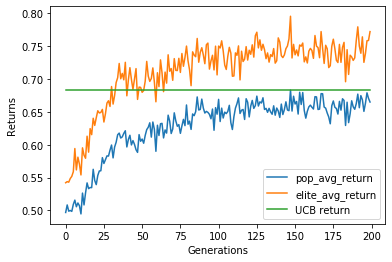

In [6]:
import random
from functools import reduce

logging.info('run_master: {}'.format(args))



# population size
psize = int(args['pop_size'])
#mutation magnitude
mag = float(args['mutation_mag'])
# number of generations
generations = int(args['max_gen'])
#number of arms
no_arms = int(args['arms'])
#Number of samples for each bandit problem
trials = int(args['trials'])

#degree of exploitation vs exploration
greedy_kill = 5
greedy_select = 5

#setting the enviroment
all_envs = []
for i in range(psize):
    envs  = [Enviroment(is_bernoulli=True, no_arms=no_arms) for _ in range(10)]
    all_envs.append(envs)

#set of elite agent
elite = [None]*int(psize/2)


# Average rewards for ES
avg_elite_rwd = 0
avg_rwd = 0
rwds = []
elite_rwds = []

#initilizing population
population = []
for _ in range(psize):
    population.append(Individual(no_arms=no_arms, mag=mag, trials=trials))  

for gen in range(generations):

    #Doing rollouts
    [indv.run(all_envs[i]) for i, indv in enumerate(population)]

    #Getting elite agent        
    for i in range(len(elite)):
        parents = random.sample(population, greedy_select)
        parent = reduce(lambda x, y: x if x.fitness > y.fitness else y, parents)
        elite[i] = copy.deepcopy(parent)

    rwds.append(np.mean([ind.fitness for ind in population]))
    elite_rwds.append(np.mean([ind.fitness for ind in elite]))
    #logging
    logging.info('Generation: {}'.format(gen))
    logging.info('pop fitness: {}'.format(np.mean([ind.fitness for ind in population])))
    logging.info('elite fitness: {}'.format(np.mean([ind.fitness for ind in elite])))
    
    if gen%50==0:
        print('Generation: ', gen)
        print('pop fitness', np.mean([ind.fitness for ind in population]))
        print('elite fitness', np.mean([ind.fitness for ind in elite]))

    #creation of new off springs, and their evaluation in MAB problems
    for j, parent in enumerate(elite):
        for i in range(int(psize/len(elite))):
            child = parent.mutate()
            child.run(all_envs[j+i])
            population.append(child)


    #Killing
    for _ in range(int(psize/len(elite))*len(elite)):
        to_kill = random.sample(population, greedy_kill)
        to_kill = reduce(lambda x, y: x if x.fitness < y.fitness else y, to_kill)
        population.remove(to_kill)



#setting UCB agent
ucb = AgentUCB(no_arms)

#Average reward of UCB agent
ucb_rwd = 0
for env in envs:
    for _ in range(trials):    
        arm = ucb.pull()
        r = env.pull_arm(arm)
        ucb_rwd += r
        ucb.update(arm, r)
    ucb.reset()

ucb_rwd /= len(envs)*trials


#Plotting the training graph
plt.plot(range(len(rwds)), rwds)
plt.plot(range(len(rwds)), elite_rwds)
plt.plot(range(len(rwds)), [ucb_rwd]*len(rwds))
plt.ylabel('Returns')
plt.xlabel('Generations') 
plt.legend(['pop_avg_return', 'elite_avg_return', 'UCB return'], loc='lower right')



if args['save_result']:
        if not args['noise']:
            plt.savefig('results/'+args['layers'] + 'x' + args['hidden'] + 'mag' + args['mutation_mag'] + 'arms' + args['arms'] + 'psize' + args['pop_size'] + 'trials' + args['trials'] + args['name'] + '/training'+'.svg', format='svg')
        else:
            plt.savefig('results/'+args['layers'] + 'x' + args['hidden'] + 'mag' + args['mutation_mag'] + 'arms' + args['arms'] + 'psize' + args['pop_size'] + 'trials' + args['trials'] + args['name'] + '/noise_training'+'.svg', format='svg')

plt.show()
#plt.close()



In [7]:
#Getting test scores

test_envs  = [Enviroment(is_bernoulli=True, no_arms=no_arms) for _ in range(10)]
test_pop = []
test_elite = []
test_ucb = []

test_cummBest_pop = []
test_cummBest_elite = []
test_cummBest_ucb = []
for env in test_envs:
    test_rwd = 0
    test_cummBest_rwd = 0
    for indv in population:
            indv.played = False
            indv.score = 0
            indv.fitness = 0
            indv.run([env], reset=False)
            test_rwd += indv.fitness
            test_cummBest_rwd += indv.score/indv.matches   
    test_pop.append(round(test_rwd/psize, 3))
    test_cummBest_pop.append(round(test_cummBest_rwd/psize, 3))

    test_rwd = 0
    test_cummBest_rwd = 0
    for indv in elite:
            indv.played = False
            indv.score = 0
            indv.fitness = 0
            indv.run([env], reset=False)
            test_rwd += indv.fitness
            test_cummBest_rwd += indv.score/indv.matches   
    test_elite.append(round(test_rwd/psize, 3))
    test_cummBest_elite.append(round(test_cummBest_rwd/psize, 3))

    test_rwd = 0
    test_cummBest_rwd = 0
    for _ in range(trials):    
            arm = ucb.pull()
            r = env.pull_arm(arm)
            test_rwd += r
            test_cummBest_rwd += int(env.best_arm==arm)
            ucb.update(arm, r)
    ucb.reset()
    test_ucb.append(round(test_rwd/trials, 3))
    test_cummBest_ucb.append(round(test_cummBest_rwd/trials, 3))



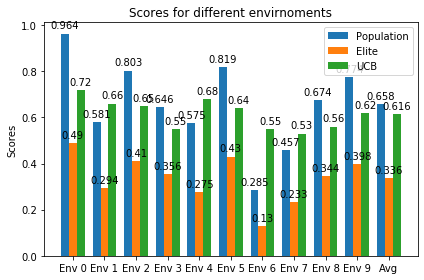

In [8]:

labels = ['Env ' + str(i) for i in range(len(test_envs))]
labels.append('Avg')

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()

test_pop.append(round(np.mean(test_pop), 3))
test_elite.append(round(np.mean(test_elite), 3))
test_ucb.append(round(np.mean(test_ucb), 3))

rects1 = ax.bar(x - width/2, test_pop, width/2, label='Population')
rects2 = ax.bar(x, test_elite, width/2, label='Elite')
rects3 = ax.bar(x + width/2, test_ucb, width/2, label='UCB')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for different envirnoments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

if args['save_result']:
        if not args['noise']:
            plt.savefig('results/'+args['layers'] + 'x' + args['hidden'] + 'mag' + args['mutation_mag'] + 'arms' + args['arms'] + 'psize' + args['pop_size'] + 'trials' + args['trials'] + args['name'] + '/testing'+'.svg', format='svg')
        else:
            plt.savefig('results/'+args['layers'] + 'x' + args['hidden'] + 'mag' + args['mutation_mag'] + 'arms' + args['arms'] + 'psize' + args['pop_size'] + 'trials' + args['trials'] + args['name'] + '/noise_testing'+'.svg', format='svg')

plt.show()
#plt.close()

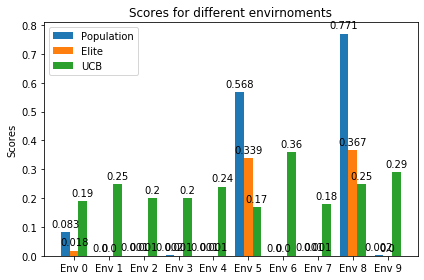

Done:


In [10]:
#Best Arm

labels = ['Env ' + str(i) for i in range(len(test_envs))]

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()


rects1 = ax.bar(x - width/2, test_cummBest_pop, width/2, label='Population')
rects2 = ax.bar(x, test_cummBest_elite, width/2, label='Elite')
rects3 = ax.bar(x + width/2, test_cummBest_ucb, width/2, label='UCB')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for different envirnoments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

if args['save_result']:
        if not args['noise']:
            plt.savefig('results/'+args['layers'] + 'x' + args['hidden'] + 'mag' + args['mutation_mag'] + 'arms' + args['arms'] + 'psize' + args['pop_size'] + 'trials' + args['trials'] + args['name'] + '/testingCummutativeBest'+'.svg', format='svg')
        else:
            plt.savefig('results/'+args['layers'] + 'x' + args['hidden'] + 'mag' + args['mutation_mag'] + 'arms' + args['arms'] + 'psize' + args['pop_size'] + 'trials' + args['trials'] + args['name'] + '/noise_testingCummutativeBest'+'.svg', format='svg')


plt.show()
#plt.close()
print('Done:' )